In [1]:
import argparse
import logging
import os
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from networks.generator import SubtleGeneratorUNet as generator
from networks.generator import CONFIGS as CONFIGS_ViT_seg
from PIL import Image

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [3]:
config_vit = CONFIGS_ViT_seg['ViT-UNet-L_8']
config_vit.window_size = 3
config_vit.transformer.encoder_num_layers = 3
config_vit.transformer.decoder_num_layers = 3

In [4]:
net = generator(config_vit, img_size=192).cuda()
net.load_state_dict(torch.load('../model/MMT/MMT_ViT-L_8_epo150_bs5_lrg0.0001_192_opt-adam/epoch_10.pth')['G'])
net.eval()

SubtleGeneratorUNet(
  (embeddings): Embeddings(
    (patch_embeddings): Conv2d(1, 1024, kernel_size=(8, 8), stride=(8, 8))
    (dropout): Dropout(p=0.0, inplace=False)
    (unfold): Unfold(kernel_size=3, dilation=1, padding=1, stride=1)
  )
  (transformer_enc): TransformerEncoder(
    (layer): ModuleList(
      (0): TransformerEncoderBlock(
        (attention_norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (ffn_norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (ffn): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (attn): AttentionRelativeBias(
          (query): Linear(in_features=1024, out_features=1024, bias=True)
          (key): Linear(in_features=1024, out_features=1024, bias=True)
          (value): Linear(in_features=1024, out_features=1024, bias=True)
          (out):

In [5]:
fn = '/raid/jiang/projects/SubtleGAN/data/brats2021_slices_crop192/test/BraTS2021_00218/090.npy'
slice_data = np.load(fn)
t1 = torch.from_numpy(slice_data[0]).unsqueeze(0).unsqueeze(0).cuda().float()
t1ce = torch.from_numpy(slice_data[1]).unsqueeze(0).unsqueeze(0).cuda().float()
t2 = torch.from_numpy(slice_data[2]).unsqueeze(0).unsqueeze(0).cuda().float()
flair = torch.from_numpy(slice_data[3]).unsqueeze(0).unsqueeze(0).cuda().float()

In [6]:
output_t1, _ = net([t1ce, t2, flair], [1, 2, 3], [0])
output_t1ce, _ = net([t1, t2, flair], [0, 2, 3], [1])
output_t2, _ = net([t1ce, t1, flair], [0, 1, 3], [2])
output_flair, _ = net([t1, t1ce, t2], [0, 1, 2], [3])

In [21]:
def save_img(img, fn):
    img = np.flipud(np.rot90(img))
    img = np.stack((img, img, img),axis=-1)
    img = np.uint8(255*img/img.max())
    im = Image.fromarray(img)
    im.save(fn)

In [22]:
def save_result(output, fn):
    plt.imshow(np.flipud(np.rot90(output[0][0][0].cpu().detach().numpy())), cmap='gray')
    plt.axis('off')
    plt.savefig(fn, bbox_inches='tight',pad_inches = 0)
    plt.close()

In [23]:
save_img(slice_data[0], 'vis/t1.png')
save_img(slice_data[1], 'vis/t1ce.png')
save_img(slice_data[2], 'vis/t2.png')
save_img(slice_data[3], 'vis/flair.png')
save_result(output_t1, 'vis/t1_o.jpg')
save_result(output_t1ce, 'vis/t1ce_o.jpg')
save_result(output_t2, 'vis/t2_o.jpg')
save_result(output_flair, 'vis/flair_o.jpg')

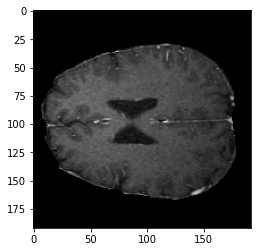

In [11]:
import matplotlib.pyplot as plt
plt.imshow(slice_data[1], cmap='gray')

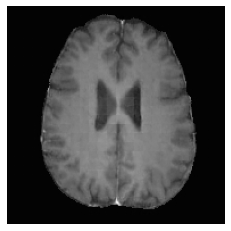

In [20]:
plt.imshow(np.flipud(np.rot90(output_t1ce[0][0][0].cpu().detach().numpy())), cmap='gray')
plt.axis('off')
plt.savefig("t1ce_o.png", bbox_inches='tight',pad_inches = 0)

torch.Size([1, 1, 256, 256])